## Importing necessary libraries

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Initial Check on Dataset

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/world.csv")
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

Dataset has 20 Columns with 227 Entries

In [9]:
df.describe()

,Population,Area (sq. mi.),GDP ($ per capita)
count,2.270000e+02,2.270000e+02,226.000000
mean,2.874028e+07,5.982270e+05,9689.823009
std,1.178913e+08,1.790282e+06,10049.138513
min,7.026000e+03,2.000000e+00,500.000000
25%,4.376240e+05,4.647500e+03,1900.000000
50%,4.786994e+06,8.660000e+04,5550.000000
75%,1.749777e+07,4.418110e+05,15700.000000
max,1.313974e+09,1.707520e+07,55100.000000


Only three columns are having proper numeric values. We can see in the previous table that most of the columns are having object as the datatype. This has to be changed.

In [10]:
## Changing the Datatype

for col in ['Country', 'Region']:
    df[col] = df[col].astype('category')
    
for col in ['Pop. Density (per sq. mi.)', 'Coastline (coast/area ratio)','Net migration','Infant mortality (per 1000 births)','Literacy (%)','Phones (per 1000)','Arable (%)','Crops (%)','Other (%)','Climate','Birthrate','Deathrate','Agriculture','Industry','Service']:
    df[col] = df[col].astype('str')
    df[col] = df[col].str.replace(",",".").astype(float)   


Country and Region columns are converted to **Category** Datatype while rest of numeric data is converted to **float**. The category data type in pandas is a hybrid data type. It looks and behaves like a string in many instances but internally is represented by an array of integers. This allows the data to be sorted in a custom order and to more efficiently store the data.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Country                             227 non-null    category
 1   Region                              227 non-null    category
 2   Population                          227 non-null    int64   
 3   Area (sq. mi.)                      227 non-null    int64   
 4   Pop. Density (per sq. mi.)          227 non-null    float64 
 5   Coastline (coast/area ratio)        227 non-null    float64 
 6   Net migration                       224 non-null    float64 
 7   Infant mortality (per 1000 births)  224 non-null    float64 
 8   GDP ($ per capita)                  226 non-null    float64 
 9   Literacy (%)                        209 non-null    float64 
 10  Phones (per 1000)                   223 non-null    float64 
 11  Arable (%)                      

In [12]:
df.describe()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


## Understanding more about the Dataset

A few of the columns: Climate, Agriculture, Industry, and Service have not been explained exactly what they include as values. We need to understand it better.

In [13]:
df.loc[:, ['Country', 'Region', 'Climate', 'Agriculture', 'Industry', 'Service']].head()

,Country,Region,Climate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),1.0,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3.0,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,1.0,0.101,0.600,0.298
3,American Samoa,OCEANIA,2.0,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,3.0,NaN,NaN,NaN


It looks like Agriculture , Industry and Service Columns represent the percent of Economy or GDP of a country that is being contributed by the respective economic activity. To understand Climate column, we can look at the distinct values and see which rows are coming together under the same value.

In [14]:
df['Climate'].unique()

array([1. , 3. , 2. , nan, 4. , 1.5, 2.5])

In [15]:
h = {}
for cat in [1, 2, 3, 4, 1.5, 2.5]:
    h[cat] = df.loc[:, ['Country', 'Region', 'Climate']][df['Climate'] == cat].head()

pd.concat([h[1], h[2], h[3], h[4], h[1.5], h[2.5]])


,Country,Region,Climate
0,Afghanistan,ASIA (EX. NEAR EAST),1.0
2,Algeria,NORTHERN AFRICA,1.0
11,Australia,OCEANIA,1.0
13,Azerbaijan,C.W. OF IND. STATES,1.0
15,Bahrain,NEAR EAST,1.0
3,American Samoa,OCEANIA,2.0
6,Anguilla,LATIN AMER. & CARIB,2.0
7,Antigua & Barbuda,LATIN AMER. & CARIB,2.0
10,Aruba,LATIN AMER. & CARIB,2.0
14,"Bahamas, The",LATIN AMER. & CARIB,2.0


A guess for what the categories are pointing to is:

**1**   - Countries that are desert kind/hot. \
**1.5** - Countries that are both hot and tropical. \
**2**   - Countries with a tropical climate.\
**2.5** - Countries that are both cold and tropical.\
**3**   - Countries with cold Climate.\
**4**   - These countries also seem to have cold climate. Not mentioned why it is separated from Category 3. 

## Data Cleaning

In [16]:
## Finding the Null Value in each Column Percentage

num_missing = df.isnull().sum()
missing_value_df = pd.DataFrame({'Column_name': df.columns,'num_missing': num_missing})
missing_value_df

,Column_name,num_missing
Country,Country,0
Region,Region,0
Population,Population,0
Area (sq. mi.),Area (sq. mi.),0
Pop. Density (per sq. mi.),Pop. Density (per sq. mi.),0
Coastline (coast/area ratio),Coastline (coast/area ratio),0
Net migration,Net migration,3
Infant mortality (per 1000 births),Infant mortality (per 1000 births),3
GDP ($ per capita),GDP ($ per capita),1
Literacy (%),Literacy (%),18


There is a very little percentage of data in each column that is missing. We can view it in a heatmap to get a different visual analysis of it. 

[Text(75.5, 0.5, 'Data Points'),
 Text(0.5, 48.5, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

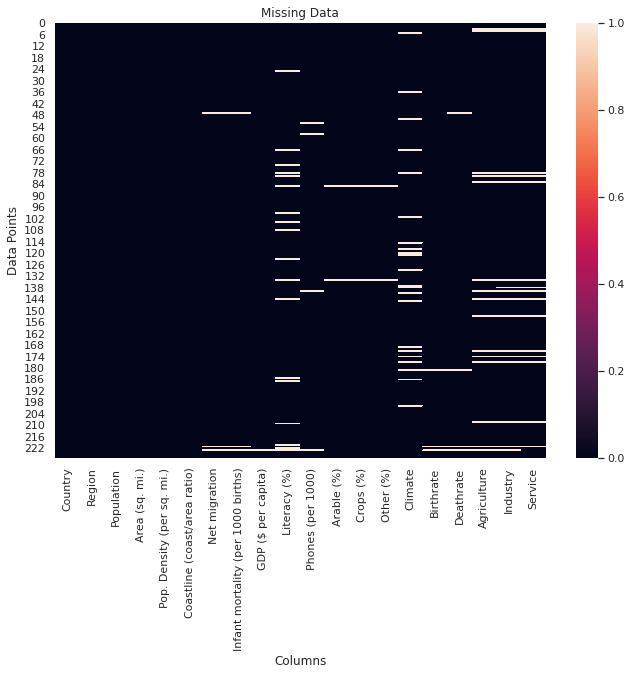

In [17]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

It is seen that there are significantly low values of **NULL** in some of the columns : **{"Net Migration", "Infant Mortality", "GDP", "Literacy", "Phones", "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture", "Industry", "Service"}**. The Rows with these values can be dealt with later for now.

In [18]:
## Checking Rows in which null values are present for each column

df1 = df[df['Net migration'].isna()]
df1

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
47,Cook Islands,OCEANIA,21388,240,89.1,50.00,NaN,NaN,5000.0,95.0,289.9,17.39,13.04,69.57,2.0,21.0,NaN,0.151,0.096,0.753
221,Wallis and Futuna,OCEANIA,16025,274,58.5,47.08,NaN,NaN,3700.0,50.0,118.6,5.00,25.00,70.00,2.0,NaN,NaN,NaN,NaN,NaN
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.0,0.42,NaN,NaN,NaN,NaN,NaN,0.02,0.00,99.98,1.0,NaN,NaN,NaN,NaN,0.400


## Changes suggested for these Rows with NaN values

| Feature   |      Number of missing Values    |  Change |
|:----------|:-------------:|------:|
| Net migration | 3 |  Belong to very small nations. Change to 0.|
| Infant mortality (per 1000 births) |  3   |Belong to very small nations. Change to 0.  |
| GDP ($ per capita) | 1| From Google search, it is \$2500. Change to same.|
|Literacy (\%)|18| Replace by the mean literacy of each missing value's region|
|Phones (per 1000)|4|Replace by the mean phones of each missing value's region|
|Arable (\%)|2|Very small islands.Change to 0.|
|Crops (\%)|2|Very small islands.Change to 0.|
|Other (\%)|2|Very small islands.Change to 0.|
|Climate|22|Change to 0. It represents "unknown" category.|
|Birthrate|3|Replace with their region's mean rates|
|Deathrate|4|Replace with their region's mean rates|
|Agriculture|15|Calculated guess seeing how similar countries have. Change to 0.15.|
|Industry|16|Calculated guess seeing how similar countries have. Change to 0.05.|
|Service|15|Calculated guess seeing how similar countries have. Change to 0.8.|

In [19]:
change1 = [("Net migration", 0), ("Infant mortality (per 1000 births)", 0), ("GDP ($ per capita)", 2500), ("Arable (%)", 0), ("Crops (%)", 0),("Other (%)",0),("Climate",0),("Agriculture",0.15), ("Industry", 0.05), ("Service", 0.8) ]
for col in change1:
    df[col[0]].fillna(col[1], inplace = True)
    
change2 = ["Literacy (%)", "Phones (per 1000)", "Birthrate", "Deathrate"]
for col in change2:
    df[col].fillna(df.groupby('Region')[col].transform('mean'), inplace= True)

In [20]:
print(df.isnull().sum())

Country                               0
Region                                0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          0
Phones (per 1000)                     0
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Climate                               0
Birthrate                             0
Deathrate                             0
Agriculture                           0
Industry                              0
Service                               0
dtype: int64


# EDA
## Correlation Heatmap

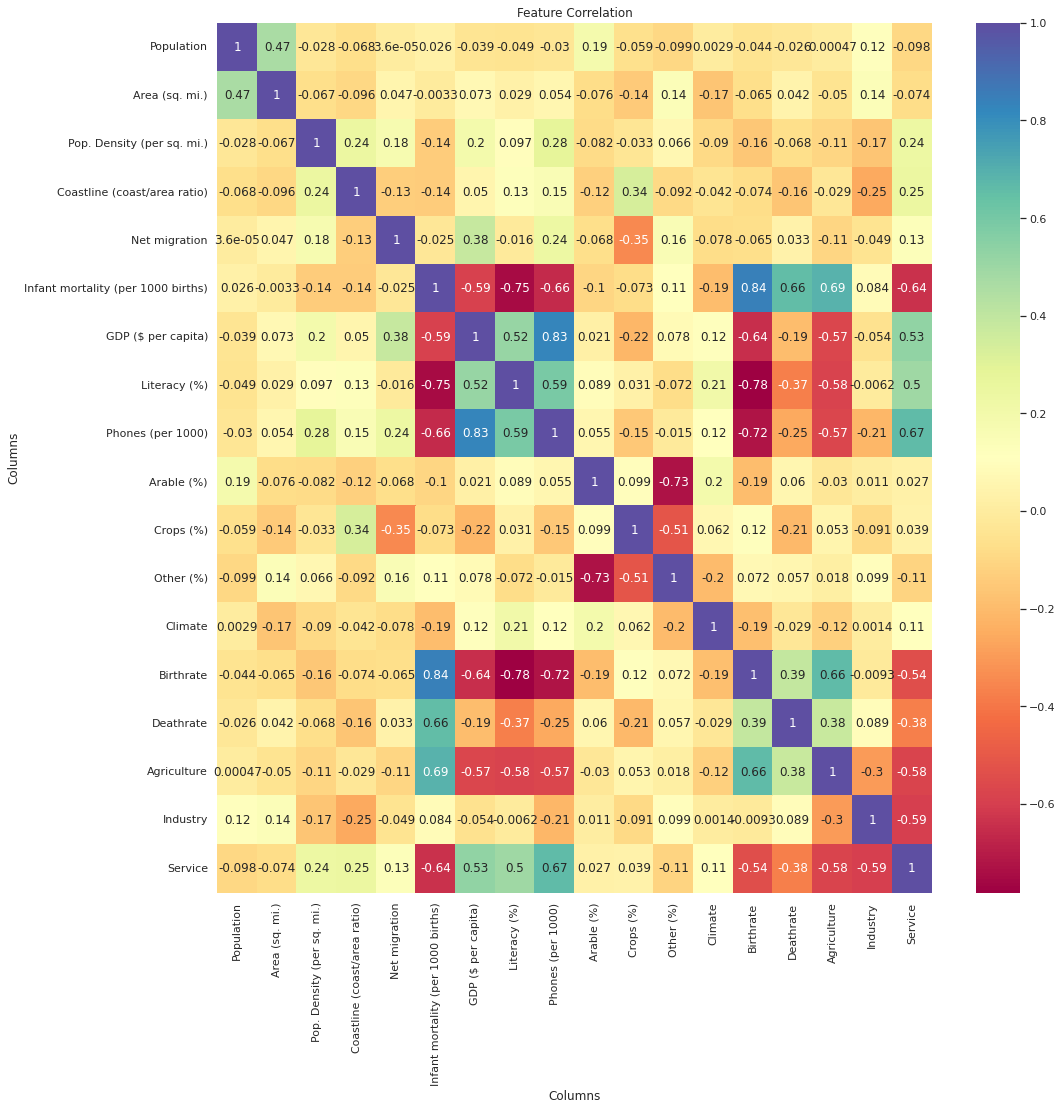

In [21]:
fig, ax = plt.subplots(figsize=(16,16)) 
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='Spectral').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

## Insights
**Expected Strong Correlation between :** 
1. Infant mortality and Birthrate 
2. Gdp per capita and Phones

**Expected Strong Anticorrelation between:**
1. Infant mortality and Literacy
2. Arable and Other 
3. Birthrate and Literacy

**Unexpected Strong Correlation between:**
1. Infant mortality and Agriculture

**Unexpected Strong Anticorrelation between:**
1. Birthrate and Phones

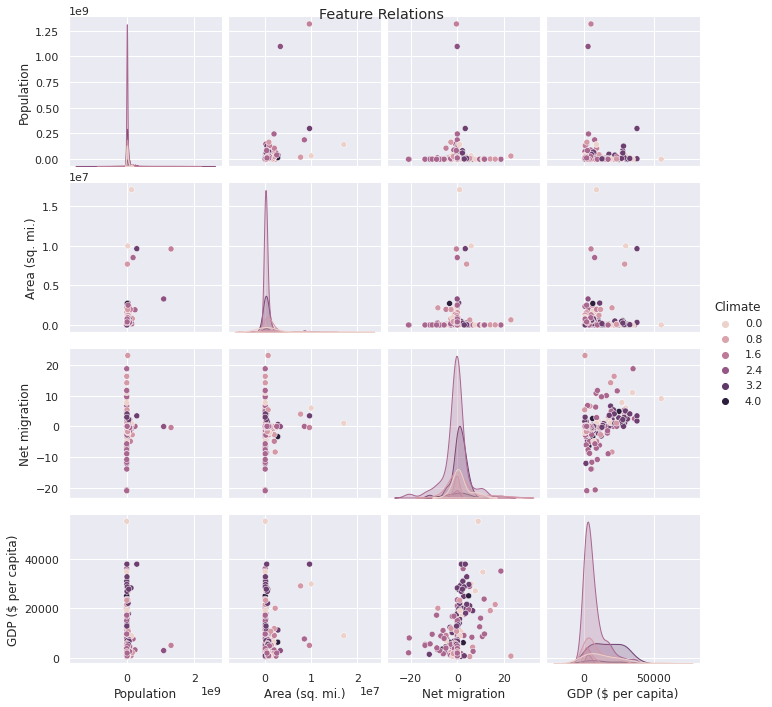

In [22]:
f = sns.pairplot(df[['Population', 'Area (sq. mi.)', 'Net migration', 'GDP ($ per capita)', 'Climate']], hue = "Climate")
f.fig.suptitle('Feature Relations')
plt.show()

There is a fair correlation between GDP and migration, which makes sense, since migrants tend to move to countries with better opportunities and higher GDP per capita.

## Regional Analysis

Checking the number of Countries in each region, the GDP per capita, population and migration to get some insights.

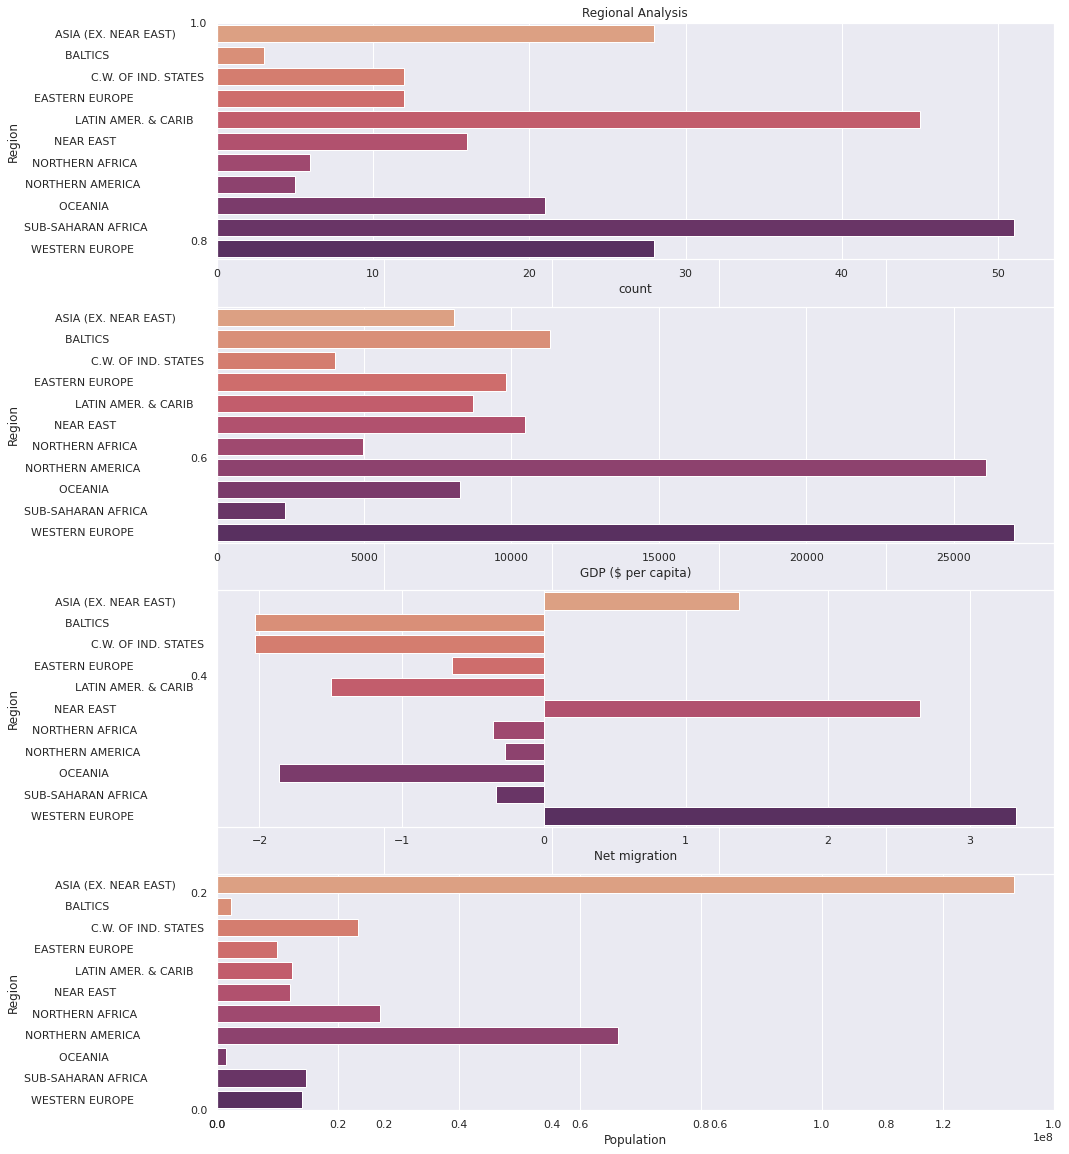

In [23]:
fig = plt.figure(figsize=(15, 20))
plt.title('Regional Analysis')
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)
sns.countplot(data= df, y= 'Region', ax= ax1, palette="flare")
sns.barplot(data= df, y= 'Region', x= 'GDP ($ per capita)', ax= ax2, palette="flare", ci= None)
sns.barplot(data= df, y= 'Region', x= 'Net migration', ax= ax3, palette="flare", ci= None)
sns.barplot(data= df, y= 'Region', x= 'Population', ax= ax4, palette="flare", ci= None)
plt.show()

## Insights
1. Sub-Saharan Africa and Latin America & Caribbean regions have the most countries.
2. Western Europe and North America have the highest GDP per capita, while Sub-Saharan Africa has the lowest GDP per capita.
3. Asia, North America, and North Europe, are the main regions where migrants from other regions go to.
4. Asia has the largest population, Oceania has the smallest.

# GDP Analysis

The relation between GDP and Infant Mortality rate, Literacy, Arable Land is studied

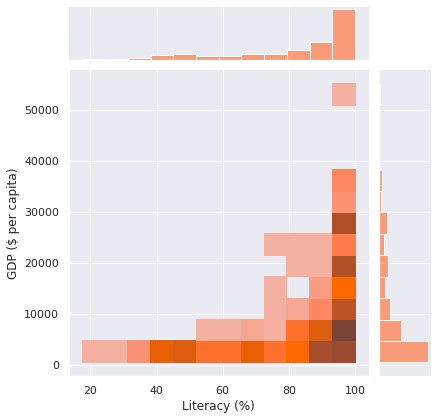

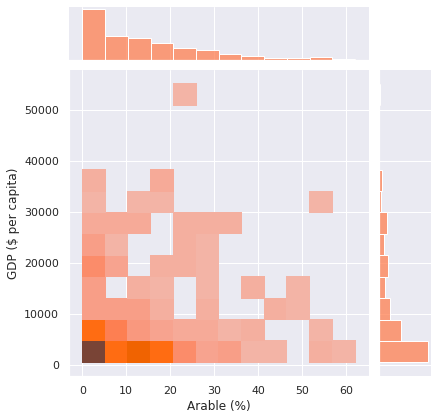

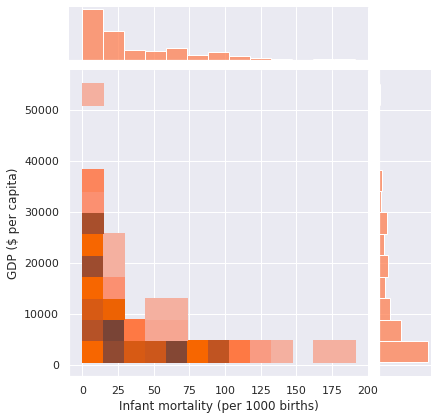

In [24]:
sns.jointplot(data= df, x= 'Literacy (%)', y= 'GDP ($ per capita)', kind= "hist",color='coral')
sns.jointplot(data= df, x= 'Arable (%)', y= 'GDP ($ per capita)', kind= "hist", color='coral')
sns.jointplot(data= df, x= 'Infant mortality (per 1000 births)', y= 'GDP ($ per capita)', kind= "hist",color='coral')
plt.show()

## Analysis 

1. Higher the country's GDP, the more literate the population is, and vice versa.
2. No clear relationship between GDP and \% of Arable land. It shows that Agriculture is not the strongest factor economically.
3. Poor countries suffer more from Infant mortality.

## Data Pre conditioning

1. Transform 'Region' column into numerical values.
2. Split data set into Training and Testing parts (80/20).
3. Trying to analyse (with/without Feature Selection, with/without Feature Scaling.

In [25]:
# Importing libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [26]:
# Transporming Region

df_final = pd.concat([df,pd.get_dummies(df['Region'], prefix='Region')], axis=1).drop(['Region'],axis=1)
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   Country                                     227 non-null    category
 1   Population                                  227 non-null    int64   
 2   Area (sq. mi.)                              227 non-null    int64   
 3   Pop. Density (per sq. mi.)                  227 non-null    float64 
 4   Coastline (coast/area ratio)                227 non-null    float64 
 5   Net migration                               227 non-null    float64 
 6   Infant mortality (per 1000 births)          227 non-null    float64 
 7   GDP ($ per capita)                          227 non-null    float64 
 8   Literacy (%)                                227 non-null    float64 
 9   Phones (per 1000)                           227 non-null    float64 
 10  Ar

Now it has 227 entries and 30 Columns.

In [27]:
# Without scaling , the full dataset
y = df_final["GDP ($ per capita)"]
X = df_final.drop(["GDP ($ per capita)",'Country'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# With Scaling
sc_X = StandardScaler()
X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

# Without scaling, Feature selected Dataset (corr > +/-0.3)
y3 = y
X3 = df_final.drop(['GDP ($ per capita)','Country','Population', 'Area (sq. mi.)', 'Coastline (coast/area ratio)', 'Arable (%)',
                      'Crops (%)', 'Other (%)', 'Climate', 'Deathrate', 'Industry'], axis=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=101)


# With scaling
sc_X4 = StandardScaler()
X4_train = sc_X4.fit_transform(X3_train)
X4_test = sc_X4.fit_transform(X3_test)
y4_train = y3_train
y4_test = y3_test

# Linear Regression 

Basic Regression Technique is seen first to see if any linear relationship exists. Model Training is done for all 4 datasets, predictions are done and it is Evaluated to see if any improvement is seen with Feature Selection or Feature Scaling. 


In [28]:
# Model Training
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

lm3 = LinearRegression()
lm3.fit(X3_train,y3_train)

lm4 = LinearRegression()
lm4.fit(X4_train,y4_train)

# Predictions
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)
lm3_pred = lm3.predict(X3_test)
lm4_pred = lm4.predict(X4_test)

# Evaluation Function 
def eval(cond, y, pred):
    print(cond)
    print("____________________________\n")
    print('MAE:', metrics.mean_absolute_error(y, pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pred)))
    print('R2_Score: ', metrics.r2_score(y, pred))
    print("*****************************\n\n")
    
eval("All features, No scaling:",y_test,lm1_pred)
eval("\nAll features, with scaling:",y2_test,lm2_pred)
eval("\nSelected features, No scaling:",y3_test,lm3_pred)
eval("\nSelected features, with scaling:",y4_test,lm4_pred)  

All features, No scaling:
____________________________

MAE: 333974.4609985466
RMSE: 1586655.0337582068
R2_Score:  -30466.567499551402
*****************************



All features, with scaling:
____________________________

MAE: 1897534093105193.5
RMSE: 2461139685996686.0
R2_Score:  -7.330697202763726e+22
*****************************



Selected features, No scaling:
____________________________

MAE: 2971.6602914968676
RMSE: 4107.9405144194425
R2_Score:  0.7957692903498332
*****************************



Selected features, with scaling:
____________________________

MAE: 2888.4511008956615
RMSE: 3766.6417449287223
R2_Score:  0.8282956156224499
*****************************




## Analysis
1. **Feature Selection** helps in reducing the errors. It is needed for this model.
2. **Feature Scaling** did not have that significant effect on the prediction performance. 
3. Decent predictions obtained with both **Selection** and **Scaling**.

# SVM

In [29]:
# Model Training
svm1 = SVR(kernel='rbf')
svm1.fit(X_train,y_train)

svm2 = SVR(kernel='rbf')
svm2.fit(X2_train,y2_train)

svm3 = SVR(kernel='rbf')
svm3.fit(X3_train,y3_train)

svm4 = SVR(kernel='rbf')
svm4.fit(X4_train,y4_train)

# Predictions
svm1_pred = svm1.predict(X_test)
svm2_pred = svm2.predict(X2_test)
svm3_pred = svm3.predict(X3_test)
svm4_pred = svm4.predict(X4_test)

# Evaluation
eval("All features, No scaling:",y_test,svm1_pred)
eval("\nAll features, with scaling:",y2_test,svm2_pred)
eval("\nSelected features, No scaling:",y3_test,svm3_pred)
eval("\nSelected features, with scaling:",y4_test,svm4_pred)  

All features, No scaling:
____________________________

MAE: 7049.984895264721
RMSE: 9811.73631340298
R2_Score:  -0.16510345624387246
*****************************



All features, with scaling:
____________________________

MAE: 7042.7210105462555
RMSE: 9800.400310705632
R2_Score:  -0.16241280378794354
*****************************



Selected features, No scaling:
____________________________

MAE: 7047.711927119429
RMSE: 9807.997922161288
R2_Score:  -0.1642157881193682
*****************************



Selected features, with scaling:
____________________________

MAE: 7040.047131938268
RMSE: 9794.568864921408
R2_Score:  -0.16102989485774888
*****************************




## Analysis

1. **Feature Scaling** and **Feature Selection**, made almost no difference in the prediction performance of the SVM algorithm.

2. The results of **SVM is worse than LR**.

## Optimising SVM
Using **Grid Search**

In [30]:
param_grid = {'C': [1, 10, 100], 'gamma': [0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=3)
grid.fit(X4_train,y4_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.324 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.156 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.115 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.372 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=rbf;, score=-0.026 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.325 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.158 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.117 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.373 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.001, kernel=rbf;, score=-0.027 total time=   0.0s
[CV 1/5] END ....C=1, gamma=0.0001, kernel=rbf;, score=-0.325 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.0001, kernel=rbf;, 

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [31]:
print("Best Parameters are : {}".format(grid.best_params_))
print("Best Estimators are : {}".format(grid.best_estimator_))
grid_predictions = grid.predict(X4_test)
eval("\nSelected features, with scaling:",y4_test,grid_predictions)

Best Parameters are : {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimators are : SVR(C=100, gamma=0.01)

Selected features, with scaling:
____________________________

MAE: 6386.205814212786
RMSE: 9132.002062615671
R2_Score:  -0.009263938588386589
*****************************




It has **improved but performance is still lower** than LR.

## Random Forest

Scaling doesn't work in this model so it is not analysed.

In [32]:
# Model Training
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf3 = RandomForestRegressor(random_state=101, n_estimators=200)
rf1.fit(X_train, y_train)
rf3.fit(X3_train, y3_train)

# Prediction
rf1_pred = rf1.predict(X_test)
rf3_pred = rf3.predict(X3_test)

# Evaluation
eval("All features, No scaling:",y_test,rf1_pred)
eval("\nSelected features, No scaling:",y3_test,rf3_pred)

All features, No scaling:
____________________________

MAE: 2125.2391304347825
RMSE: 3051.7076634309974
R2_Score:  0.8872909963146485
*****************************



Selected features, No scaling:
____________________________

MAE: 2452.336956521739
RMSE: 3565.861787568817
R2_Score:  0.846113059222144
*****************************




## Optimising Random Forest

**Grid Search** will be used to get optimal parameters. Only parameters chosen are n-estimators, min_samples_leaf, max_features, bootstrap.

In [33]:
## Choosing params
rf_param_grid = {'max_features': ['sqrt', 'auto'],
              'min_samples_leaf': [1, 3, 5],
              'n_estimators': [100, 500, 1000],
             'bootstrap': [False, True]} 

rf_grid = GridSearchCV(estimator= RandomForestRegressor(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)
rf_grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 500, 1000]})

In [34]:
print("Best Parameters are : {}".format(rf_grid.best_params_))
print("Best Estimators are : {}".format(rf_grid.best_estimator_))
rf_grid_predictions = rf_grid.predict(X_test)
eval("\nAll features, no scaling:",y_test,rf_grid_predictions)

Best Parameters are : {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}
Best Estimators are : RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=1000)

All features, no scaling:
____________________________

MAE: 2297.228260869565
RMSE: 3137.9425789007455
R2_Score:  0.8808311526862287
*****************************




## Analysis

1. Optimization process on RF regressor **has not changed the performance** in a significant manner.

# Gradient Boosting

In [35]:
# Model training
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)
gbm3 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)

gbm1.fit(X_train, y_train)
gbm3.fit(X3_train, y3_train)

# Prediction
gbm1_pred = gbm1.predict(X_test)
gbm3_pred = gbm3.predict(X3_test)

# Evaluation
eval("All features, No scaling:",y_test,gbm1_pred)
eval("\nSelected features, No scaling:",y3_test,gbm3_pred)

All features, No scaling:
____________________________

MAE: 2244.6730986063285
RMSE: 3367.0344774483683
R2_Score:  0.8627956498687702
*****************************



Selected features, No scaling:
____________________________

MAE: 2452.644806376521
RMSE: 3888.8637029732886
R2_Score:  0.8169717199096127
*****************************




# Optimising GBM
Grid Search will be used to get optimal parameters. Only parameters chosen are n-estimators , learning_rate , max_depth , subsample , min_samples_leaf , min_samples_split , max_features.

In [36]:
## Choosing params
gbm_param_grid = {'learning_rate':[1,0.1, 0.01, 0.001], 
           'n_estimators':[100, 500, 1000],
          'max_depth':[3, 5, 8],
          'subsample':[0.7, 1], 
          'min_samples_leaf':[1, 20],
          'min_samples_split':[10, 20],
          'max_features':[4, 7]}

gbm_tuning = GridSearchCV(estimator =GradientBoostingRegressor(random_state=101),
                          param_grid = gbm_param_grid,
                          n_jobs=-1,
                          cv=5)
gbm_tuning.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=101),
             n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 8], 'max_features': [4, 7],
                         'min_samples_leaf': [1, 20],
                         'min_samples_split': [10, 20],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.7, 1]})

In [37]:
print("Best Parameters are : {}".format(gbm_tuning.best_params_))
print("Best Estimators are : {}".format(gbm_tuning.best_estimator_))
gbm_grid_predictions = gbm_tuning.predict(X_test)
eval("\nAll features, no scaling:",y_test,gbm_grid_predictions)

Best Parameters are : {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.7}
Best Estimators are : GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features=7,
                          min_samples_split=10, n_estimators=500,
                          random_state=101, subsample=0.7)

All features, no scaling:
____________________________

MAE: 2293.645950161285
RMSE: 3382.9123897065074
R2_Score:  0.861498570635607
*****************************




## Analysis

1. Gradient Boosting **gave a good performance** even before Optimisation.
2. Grid search **actually decreased the GBM performance** a bit. In general, we can say that GBM has a similar performance to that of Random Forest on our dataset.

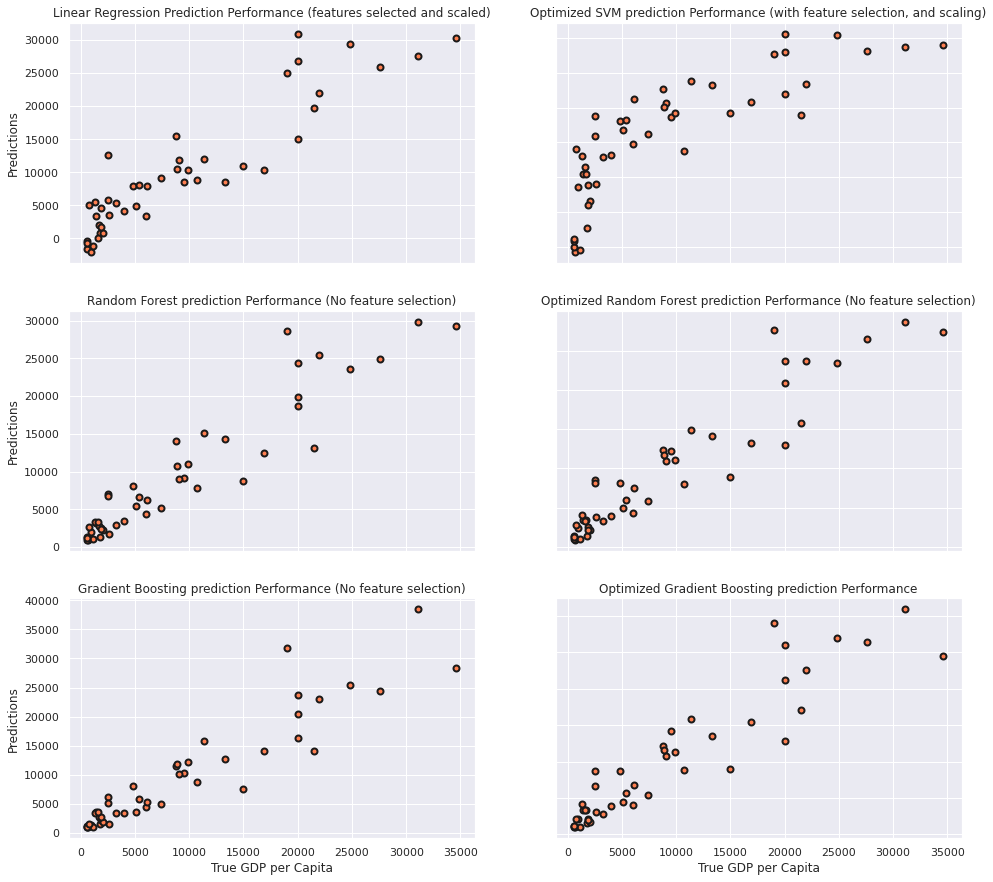

In [38]:
## Conclusion Plots 
fig, axs = plt.subplots(3, 2, figsize=(16,15))
axs[0, 0].scatter(y4_test,lm4_pred,color='coral', linewidths=2, edgecolors='k')
axs[0, 0].set_title('Linear Regression Prediction Performance (features selected and scaled)')
axs[0, 1].scatter(y4_test,grid_predictions,color='coral', linewidths=2, edgecolors='k')
axs[0, 1].set_title('Optimized SVM prediction Performance (with feature selection, and scaling)')
axs[1, 0].scatter(y_test,rf1_pred,color='coral', linewidths=2, edgecolors='k')
axs[1, 0].set_title('Random Forest prediction Performance (No feature selection)')
axs[1, 1].scatter(y_test,rf_grid_predictions,color='coral', linewidths=2, edgecolors='k')
axs[1, 1].set_title('Optimized Random Forest prediction Performance (No feature selection)')
axs[2, 0].scatter(y_test,gbm1_pred,color='coral', linewidths=2, edgecolors='k')
axs[2, 0].set_title('Gradient Boosting prediction Performance (No feature selection)')
axs[2, 1].scatter(y_test,gbm_grid_predictions,color='coral', linewidths=2, edgecolors='k')
axs[2, 1].set_title('Optimized Gradient Boosting prediction Performance')

for ax in axs.flat:
    ax.set(xlabel='True GDP per Capita', ylabel='Predictions')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

**Random Forest shows the best prediction performance**

## Feature Importance



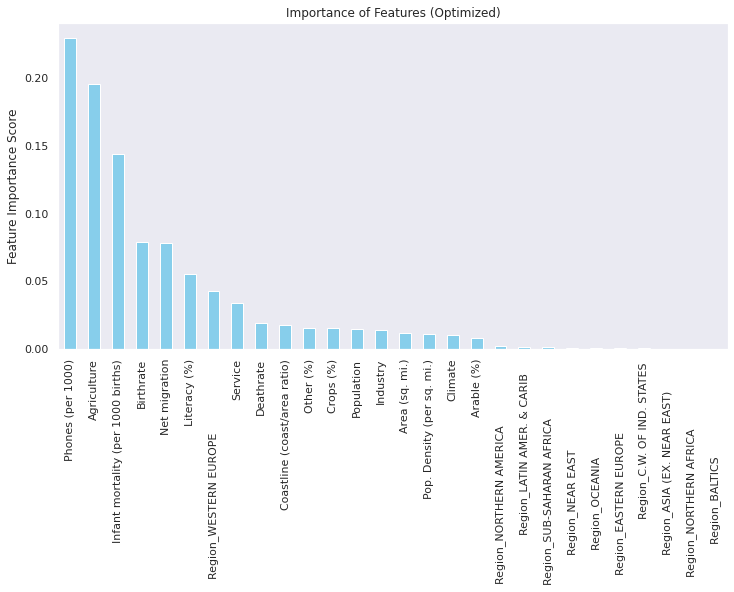

In [39]:
gbm_opt = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500,max_depth=5, min_samples_split=10, min_samples_leaf=1, 
                                    subsample=0.7,max_features=7, random_state=101)
gbm_opt.fit(X_train,y_train)
feat_imp2 = pd.Series(gbm_opt.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp2.plot(kind='bar', title='Importance of Features (Optimized)', color= 'skyblue')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

## Analysis

1. This shows significant importance shown by some features like Phones, Agriculture, Infant mortality etc.
2. Comparatively, the importance of Arable or Area is very less.

# Conclusion

4 different learning regressors **(Linear Regression, SVM, Random Forest, and Gradiant Boosting)** were tested to predict GDP, and the best prediction performance was seen in the order : \
\
**Random Forest > Gradiant Boosting > Linear Regression > SVM**

The Metrics for the best prediction performance using Random Forest regressor, using all features in the dataset is:

1. MAE: 2125.24
2. RMSE: 3051.71
3. R2_Score:  0.8873